In [1]:
import pandas
import os.path
import collections


Data = collections.namedtuple('Data', ['mnist', 'cifar'])
def load_dataset_files(filename, data_dirs={"cifar": "cifar-data", "mnist": "mnist-data"}, **kwargs):
    dataframes = {
        dataset_name: pandas.read_csv(os.path.join(data_dir, filename), **kwargs)
        for dataset_name, data_dir in data_dirs.items()
    }

    return Data(**dataframes)
        
        

fetch_size_data = load_dataset_files("fetch-size-results.csv", converters={"Miss Rate": lambda percentage: float(percentage.rstrip('%'))/100})
cache_size_data = load_dataset_files("cache-size-results.csv", converters={"Miss Rate": lambda percentage: float(percentage.rstrip('%'))/100})

In [2]:
import collections

BATCH_SIZE = 512
def get_bucketed_data(data, bucket_field, *fields, average_over_bucket_field=True, batch_size=BATCH_SIZE):
    res = []
    for epoch in data['Epoch'].drop_duplicates():    
        epoch_data = data.loc[(data['Epoch'] == epoch) & (data['Batch Size'] == batch_size)][[bucket_field, *fields]]
        if average_over_bucket_field:
            epoch_data = epoch_data.groupby(bucket_field).mean()
        res.append(epoch_data)
        
    return res

In [3]:
from matplotlib import pyplot as plt
import inflect
import numpy
import functools

plt.rcParams.update({'font.size': 14})

BAR_WIDTH = 0.2
HATCHES = ['', '...']
COLORS = ['deeppink', 'tab:cyan']
COLORS2 = [
    ['lightskyblue', 'royalblue'],
    ['plum', 'magenta']
]
DATASET_DISPLAY_NAMES = {"mnist": "MNIST", "cifar": "CIFAR-10"}

inflect_engine = inflect.engine()


def make_bucketed_graph(data, bucket_field, dependent_field, labels=None, xlabel_override=None, title_suffix="", batch_size=BATCH_SIZE):
    bucketed_data = Data(*[
        get_bucketed_data(item, bucket_field, dependent_field, average_over_bucket_field=False, batch_size=batch_size)
        for item in data
    ])

    plt.figure(figsize=(10,4))
    for dataset_index, (data, dataset_name) in enumerate(zip(bucketed_data, bucketed_data._fields)):
        for epoch, epoch_times in enumerate(data):
            epoch_name = inflect_engine.number_to_words(inflect_engine.ordinal(epoch + 1)) + " Epoch"
            epoch_name = epoch_name[0].upper() + epoch_name[1:]
            bucket_items = collections.defaultdict(list)

            for _, row in epoch_times.iterrows():
                bucket = row[bucket_field]
                dependent_res = row[dependent_field]
                bucket_items[bucket].append(dependent_res)

            averages = {
                bucket: sum(items)/len(items)
                for bucket, items in bucket_items.items()
            }
            errors = {
                bucket: numpy.std(data)
                for bucket, data in bucket_items.items()       
            }

            x, y = zip(*averages.items())
            x_ticks = numpy.arange(len(x))
            errs = [errors[cache_size] for cache_size in x]
            bar_shift = BAR_WIDTH * (epoch + (2 * dataset_index)) - BAR_WIDTH * 3/ (len(data))
            plt.bar(
                numpy.array(x_ticks) + bar_shift,
                y,
                BAR_WIDTH,
                capsize=4,
                label=f"{epoch_name} ({DATASET_DISPLAY_NAMES[dataset_name]})",
                hatch=HATCHES[dataset_index],
                color=COLORS2[dataset_index][epoch],
                edgecolor="white",
                linewidth=0
            )
            # error_shift = BAR_WIDTH * 0.4 * (dataset_index) - 0.25 * BAR_WIDTH
            error_shift = 0
            plt.errorbar(numpy.array(x_ticks) - error_shift + bar_shift, y, yerr=errs, fmt='none', barsabove=True, color='black', capsize=4)
            if labels:
                plt.xticks(x_ticks, labels)
            else:
                plt.xticks(x_ticks, [int(item) for item in x])
            plt.legend()
            plt.title(f"{dependent_field} vs {bucket_field}" + title_suffix)
            if xlabel_override:
                plt.xlabel(xlabel_override)
            else:
                plt.xlabel(bucket_field)
            plt.ylabel(dependent_field)

    plt.grid(axis='y', alpha=0.5)
    # plt.savefig(f"Combined {dependent_field} vs {bucket_field} (bs={batch_size}).png", dpi=800)
    # plt.savefig(f"Combined {dependent_field} vs {bucket_field} (bs={batch_size}).png", bbox_inches="tight", dpi=300)

        

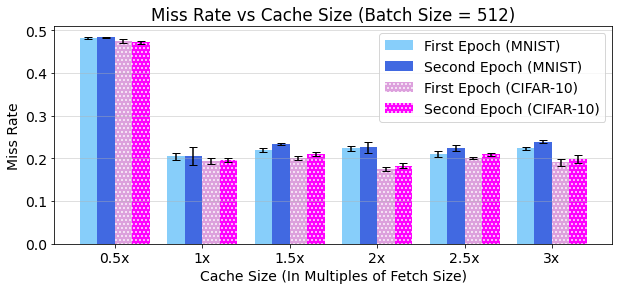

In [4]:
make_bucketed_graph(cache_size_data, "Cache Size", "Miss Rate", ["0.5x", "1x", "1.5x", "2x", "2.5x", "3x"], "Cache Size (In Multiples of Fetch Size)", " (Batch Size = 512)", batch_size=512)

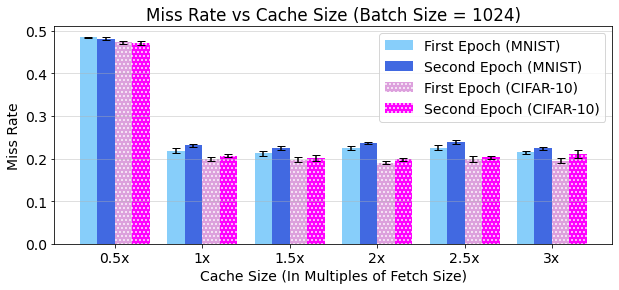

In [5]:
make_bucketed_graph(cache_size_data, "Cache Size", "Miss Rate", ["0.5x", "1x", "1.5x", "2x", "2.5x", "3x"], "Cache Size (In Multiples of Fetch Size)", " (Batch Size = 1024)", batch_size=1024)

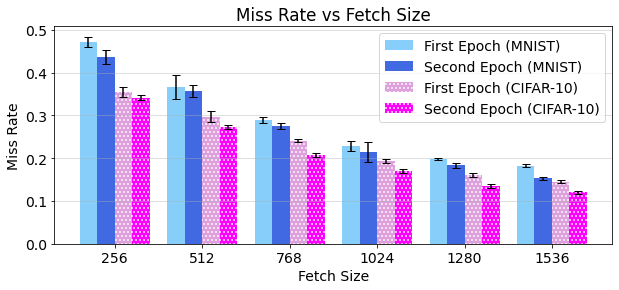

In [6]:
make_bucketed_graph(fetch_size_data, "Fetch Size", "Miss Rate")